# tf-idf: From Test to Hyppothesis Testing

In [1]:
# Libraries

import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import numpy as np
import re
import sys
import os
tqdm.pandas()

In [2]:
%matplotlib inline

# Add the directory containing visualization_utils.py to path
sys.path.append("/Users/debr/English-Homer/")
import visualization_utils as viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# palette astroblue   orange   genoa      carrot    tawny     neptune      SELAGO    mako   black
color = ['#003D59', '#FD6626','#177070','#FB871D','#641B5E','#86C3BC','#F5E1FD','#414A4F','k']
danB_plotstyle = {'figure.figsize': (12, 7), 
               'axes.labelsize': 'large', # fontsize for x and y labels (was large)
               'axes.titlesize': 'large', # fontsize for title
               'axes.titleweight': 'bold', # font type for title
               'xtick.labelsize': 'large', # fontsize for x 
               'ytick.labelsize':'small', # fontsize fory ticks
               'grid.color': 'k', # grid color
                'grid.linestyle': ':', # grid line style
                'grid.linewidth': 0.2, # grid line width
                'font.family': 'Times New Roman', # font family
                'grid.alpha': 0.5, # transparency of grid
               'figure.dpi': 300, # figure display resolution
               'savefig.bbox': 'tight', # tight bounding box
               'savefig.pad_inches': 0.4, # padding to use when saving
               'axes.titlepad': 15, # title padding
               'axes.labelpad': 8, # label padding
               'legend.borderpad': .6, # legend border padding
               'axes.prop_cycle': plt.cycler(
                color=color) # color cycle for plot lines
               }

# adjust matplotlib defaults
plt.rcParams.update(danB_plotstyle)

In [3]:
# Load CSVs
filepath_Wilson = "/Users/debr/odysseys_en/Odyssey_dfs/Odyssey_Wilson_eda_END.csv"
filepath_Green = "/Users/debr/odysseys_en/Odyssey_dfs/Odyssey_Green_eda_END.csv"

df_W = pd.read_csv(filepath_Wilson)
df_G = pd.read_csv(filepath_Green)

# Add translation label
df_W["translation"] = "Wilson"
df_G["translation"] = "Green"

# merging "book_num" with "translation" to create a unique identifier
df_W["book_id"] = df_W["book_num"].astype(str) + "_W"
df_W = df_W.drop(columns=["book_num"])
df_G["book_id"] = df_G["book_num"].astype(str) + "_G"
df_G = df_G.drop(columns=["book_num"])

# Keep only necessary columns: book number & tokens
df_W = df_W[["book_id", "tokens"]]
df_G = df_G[["book_id", "tokens"]]

# Combine both into one DataFrame
df = pd.concat([df_W, df_G], ignore_index=True)

# Ensure tokens are stored as lists (if stored as strings, convert them)
df["tokens"] = df["tokens"].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [4]:
import pandas as pd
import numpy as np
from collections import Counter

def calculate_tfidf(df):
    """
    Calculate TF-IDF scores for a DataFrame with book_id and tokens columns.
    
    Parameters:
    -----------
    df : pandas DataFrame
        A DataFrame with 'book_id' and 'tokens' columns. 
        The 'tokens' column should contain lists of tokens (as strings or actual lists).
    
    Returns:
    --------
    pandas DataFrame
        The original DataFrame with additional columns:
        - term_freq: Dictionary of term frequencies for each token
        - term_counts: Dictionary of raw counts for each token
        - idf: Dictionary of IDF scores for each token
        - tf_idf: Dictionary of TF-IDF scores for each token
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    # Function to compute term frequency and term counts
    def term_freq_by_doc(list_of_tokens):
        # Handle both string representation of list and actual list
        if isinstance(list_of_tokens, str):
            token_list = eval(list_of_tokens)  # Convert string representation to list
        else:
            token_list = list_of_tokens  # Use as is if already a list
        
        # Count occurrences of each term
        term_counts = Counter(token_list)
        
        # Total number of terms in the document
        total_terms = len(token_list)
        
        # Compute TF: term frequency for each token
        term_freq = {term: count / total_terms for term, count in term_counts.items()}
        
        return term_freq, term_counts
    
    # Apply function to compute TF for each book
    result_df["term_freq"], result_df["term_counts"] = zip(*result_df["tokens"].apply(term_freq_by_doc))
    
    # Get total number of documents (books)
    N = len(result_df)
    
    # Count how many documents contain each term
    doc_containing_term = Counter()
    for term_counts in result_df["term_freq"]:
        doc_containing_term.update(term_counts.keys())  # Count unique terms in each document
    
    # Compute IDF for each term
    idf_scores = {term: np.log(N / (1 + doc_count)) for term, doc_count in doc_containing_term.items()}  # Adding 1 to avoid division by zero
    
    # Add IDF column to df
    result_df["idf"] = result_df["term_freq"].apply(lambda term_freq: {term: idf_scores[term] for term in term_freq})
    
    # Compute TF-IDF by multiplying TF and IDF for each term in each document
    result_df["tf_idf"] = result_df.apply(lambda row: {term: row["term_freq"][term] * row["idf"][term] for term in row["term_freq"]}, axis=1)
    
    return result_df

# Example usage:
df_tfidf_W = calculate_tfidf(df_W)
df_tfidf_G = calculate_tfidf(df_G)

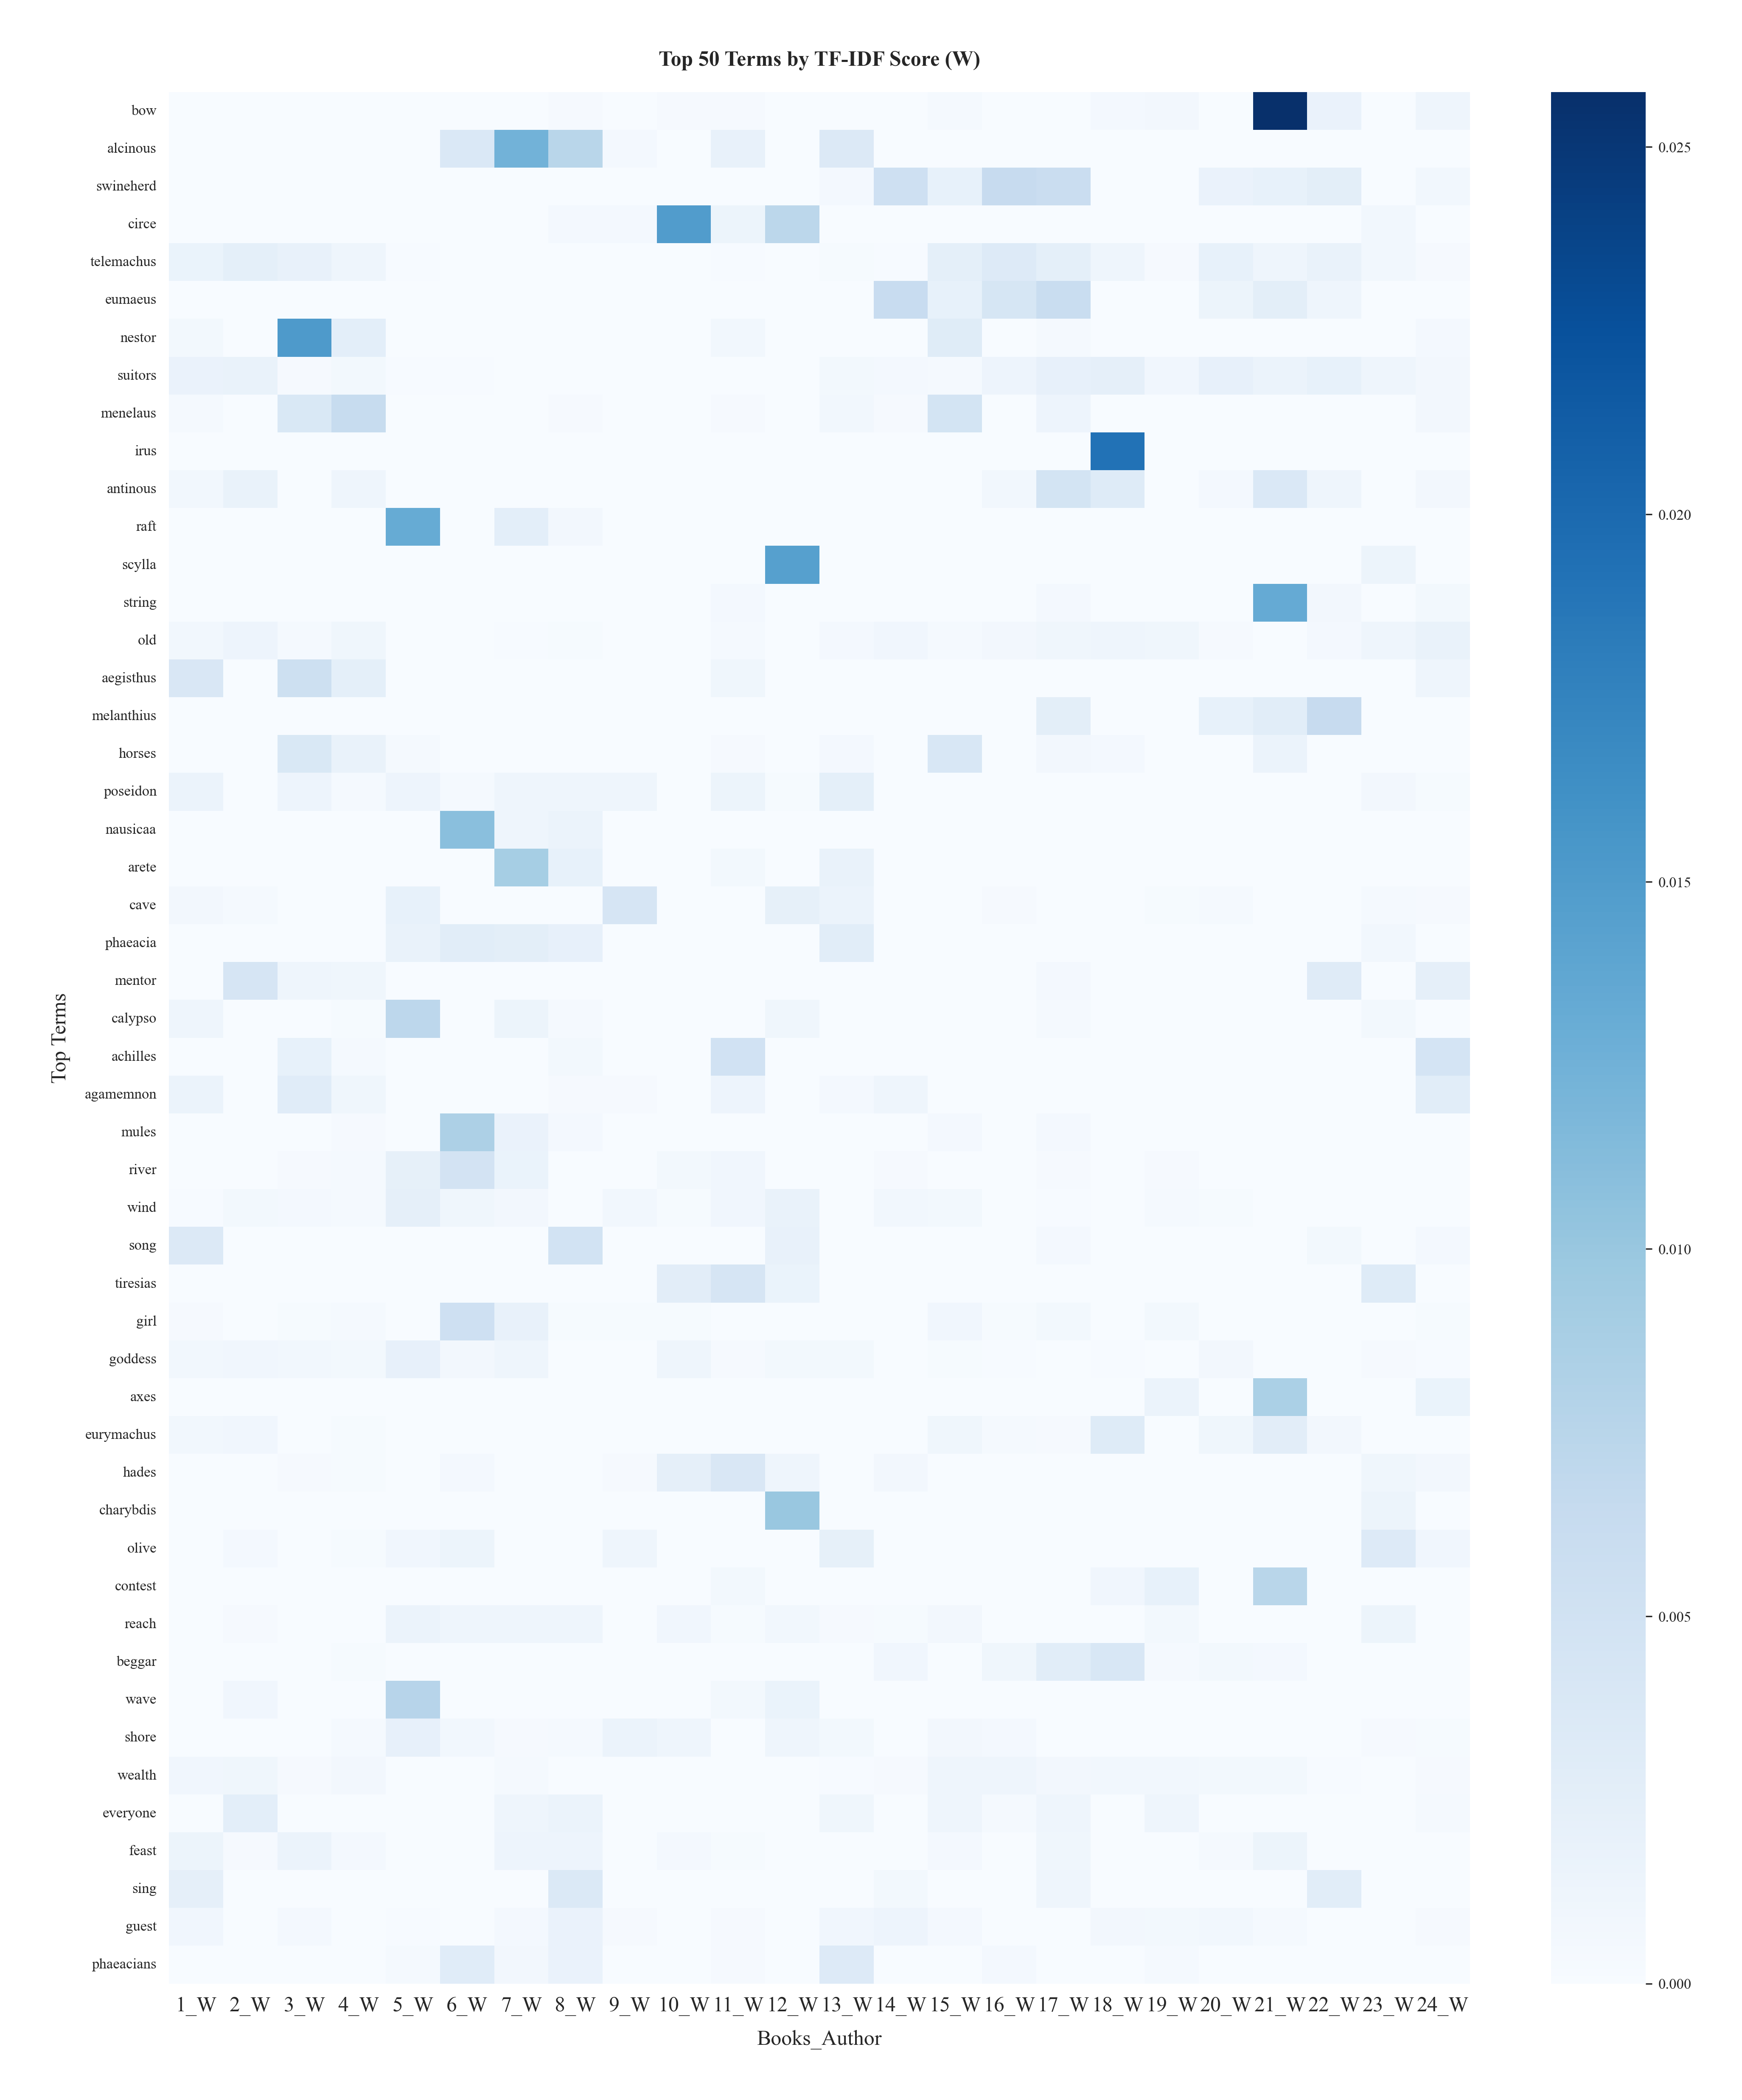

In [5]:
# Top terms for each book and heatmap plot

def extract_top_terms(df, n=50):
    """
    Extract the top N most important terms from the tf_idf column
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'book_id' and 'tf_idf' columns
    n : int
        Number of top terms to extract (default: 50)
    
    Returns:
    --------
    tuple
        (top_terms_per_book, top_terms_overall)
        - top_terms_per_book: DataFrame with top terms for each book
        - top_terms_overall: DataFrame with top terms across all books
    """
    # Extract top terms per book
    top_terms_per_book = {}
    
    for _, row in df.iterrows():
        book_id = row['book_id']
        tf_idf_dict = row['tf_idf']
        
        # Sort terms by tf-idf score (descending) and take top N
        sorted_terms = sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True)[:n]
        top_terms_per_book[book_id] = {term: score for term, score in sorted_terms}
    
    # Convert to DataFrame for easier analysis
    top_terms_df = pd.DataFrame.from_dict(top_terms_per_book, orient='index')
    
    # Extract top terms overall
    all_terms = {}
    for tf_idf_dict in df['tf_idf']:
        for term, score in tf_idf_dict.items():
            if term in all_terms:
                all_terms[term] += score
            else:
                all_terms[term] = score
    
    # Sort terms by total tf-idf score (descending) and take top N
    top_terms_overall = sorted(all_terms.items(), key=lambda x: x[1], reverse=True)[:n]
    
    # Convert to DataFrame
    top_terms_overall_df = pd.DataFrame(top_terms_overall, columns=['term', 'total_score'])
    
    return top_terms_df, top_terms_overall_df

def create_tfidf_heatmap(df, top_n=50):
    """
    Create a heatmap of the top N terms across all books
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'book_id' and 'tf_idf' columns
    top_n : int
        Number of top terms to include in the heatmap (default: 50)
    """
    # Extract top terms overall
    _, top_terms = extract_top_terms(df, n=top_n)
    top_terms_list = top_terms['term'].tolist()
    
    # Create a matrix of book_id x top_terms
    heatmap_data = []
    book_ids = []
    
    for _, row in df.iterrows():
        book_id = row['book_id']
        book_ids.append(book_id)
        
        tf_idf_dict = row['tf_idf']
        
        # Extract scores for top terms
        scores = [tf_idf_dict.get(term, 0) for term in top_terms_list]
        heatmap_data.append(scores)
    
    # Convert to numpy array
    heatmap_array = np.array(heatmap_data).T
    
    # Create heatmap
    plt.figure(figsize=(14, 16))
    sns.heatmap(heatmap_array, cmap='Blues', xticklabels=book_ids, yticklabels=top_terms_list)
    plt.title(f'Top {top_n} Terms by TF-IDF Score ({df["book_id"].iloc[0][2:]})')
    plt.xlabel('Books_Author')
    plt.ylabel('Top Terms')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"/Users/debr/English-Homer/MVP_Green-Wilson/plots/tfidf_heatmap({df['book_id'].iloc[0][2:]}).png")    
    plt.show()
    
    return heatmap_array

top_terms_per_book_W, top_terms_overall_W = extract_top_terms(df_tfidf_W)
heatmap_array = create_tfidf_heatmap(df_tfidf_W)

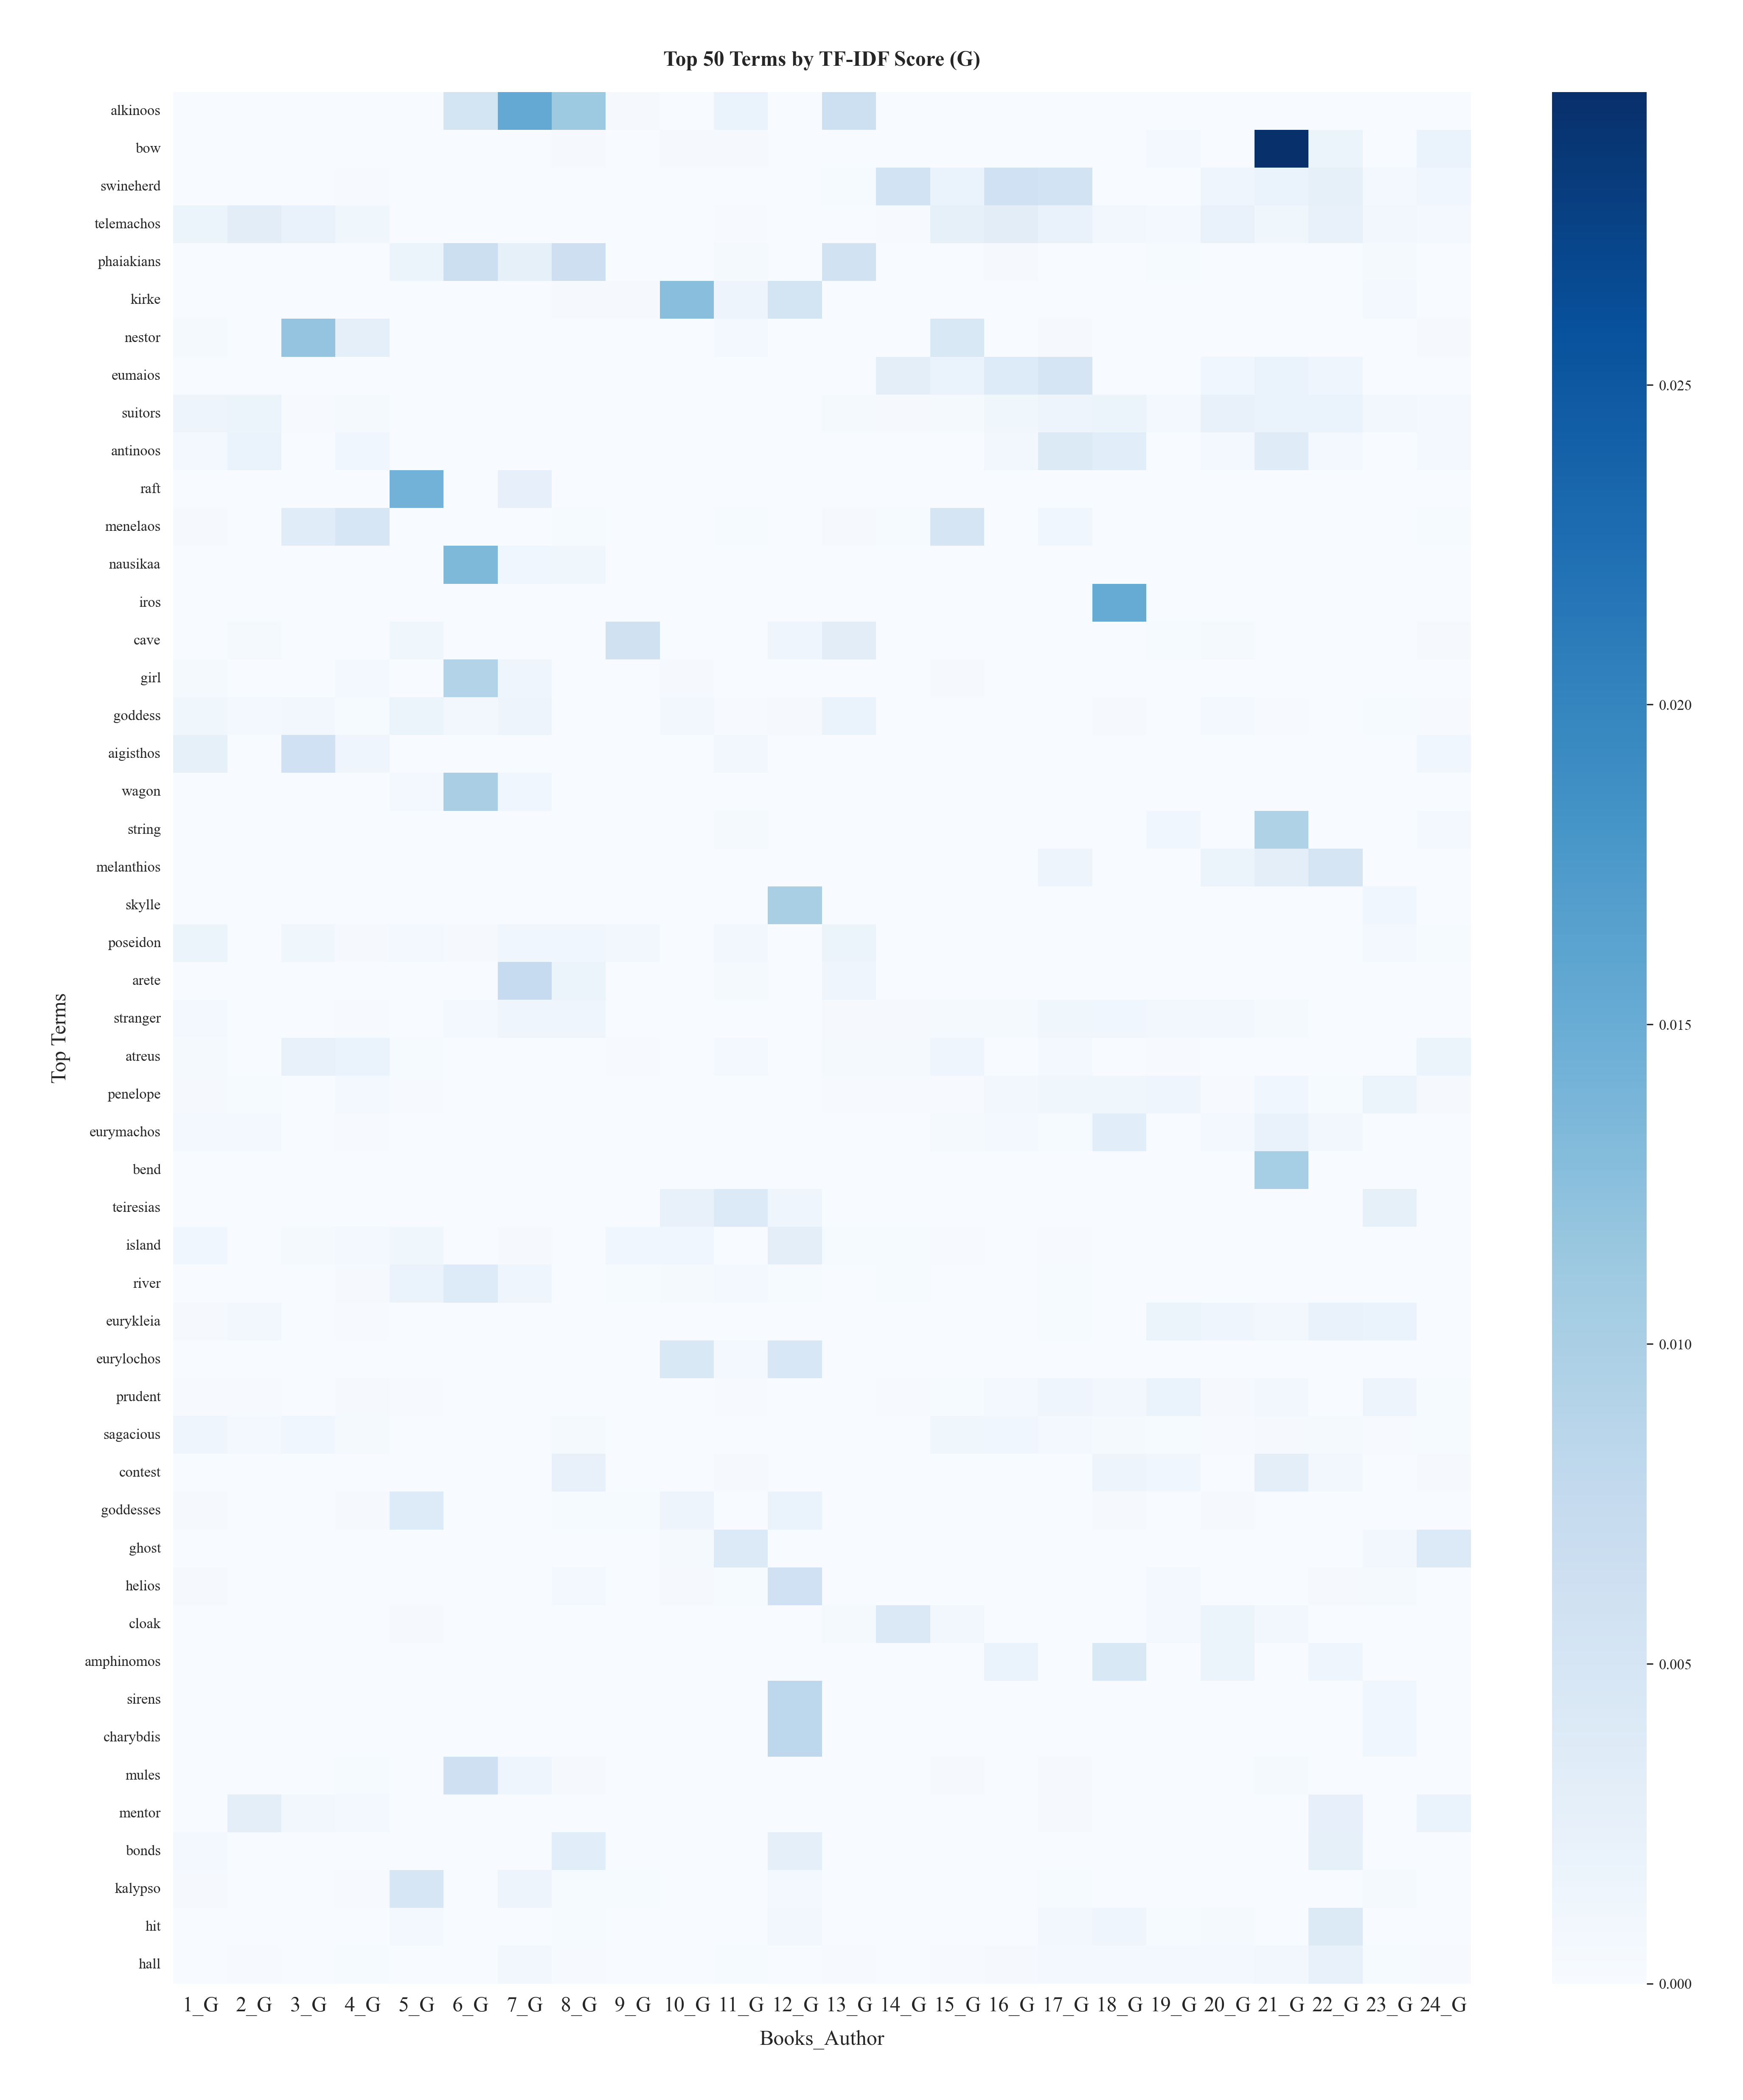

In [6]:
top_terms_per_book_G, top_terms_overall_G = extract_top_terms(df_tfidf_G)
heatmap_array = create_tfidf_heatmap(df_tfidf_G)

In [7]:
# Getting the 30 top terms for each translation
tt_W = top_terms_overall_W['term'][:30]
tt_G = top_terms_overall_G['term'][:30]
# New df with the top terms from both for comparison
top_terms_overall = pd.DataFrame({'Wilson': tt_W, 'Green': tt_G})
top_terms_overall.T


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Wilson,bow,alcinous,swineherd,circe,telemachus,eumaeus,nestor,suitors,menelaus,irus,...,arete,cave,phaeacia,mentor,calypso,achilles,agamemnon,mules,river,wind
Green,alkinoos,bow,swineherd,telemachos,phaiakians,kirke,nestor,eumaios,suitors,antinoos,...,melanthios,skylle,poseidon,arete,stranger,atreus,penelope,eurymachos,bend,teiresias


In [ ]:
# Calculate the sum of the tf-idf scores for each translation
itidf_W = df_tfidf_W["tf_idf"].apply(lambda x: list(x.values())).sum()
itidf_G = df_tfidf_G["tf_idf"].apply(lambda x: list(x.values())).sum()

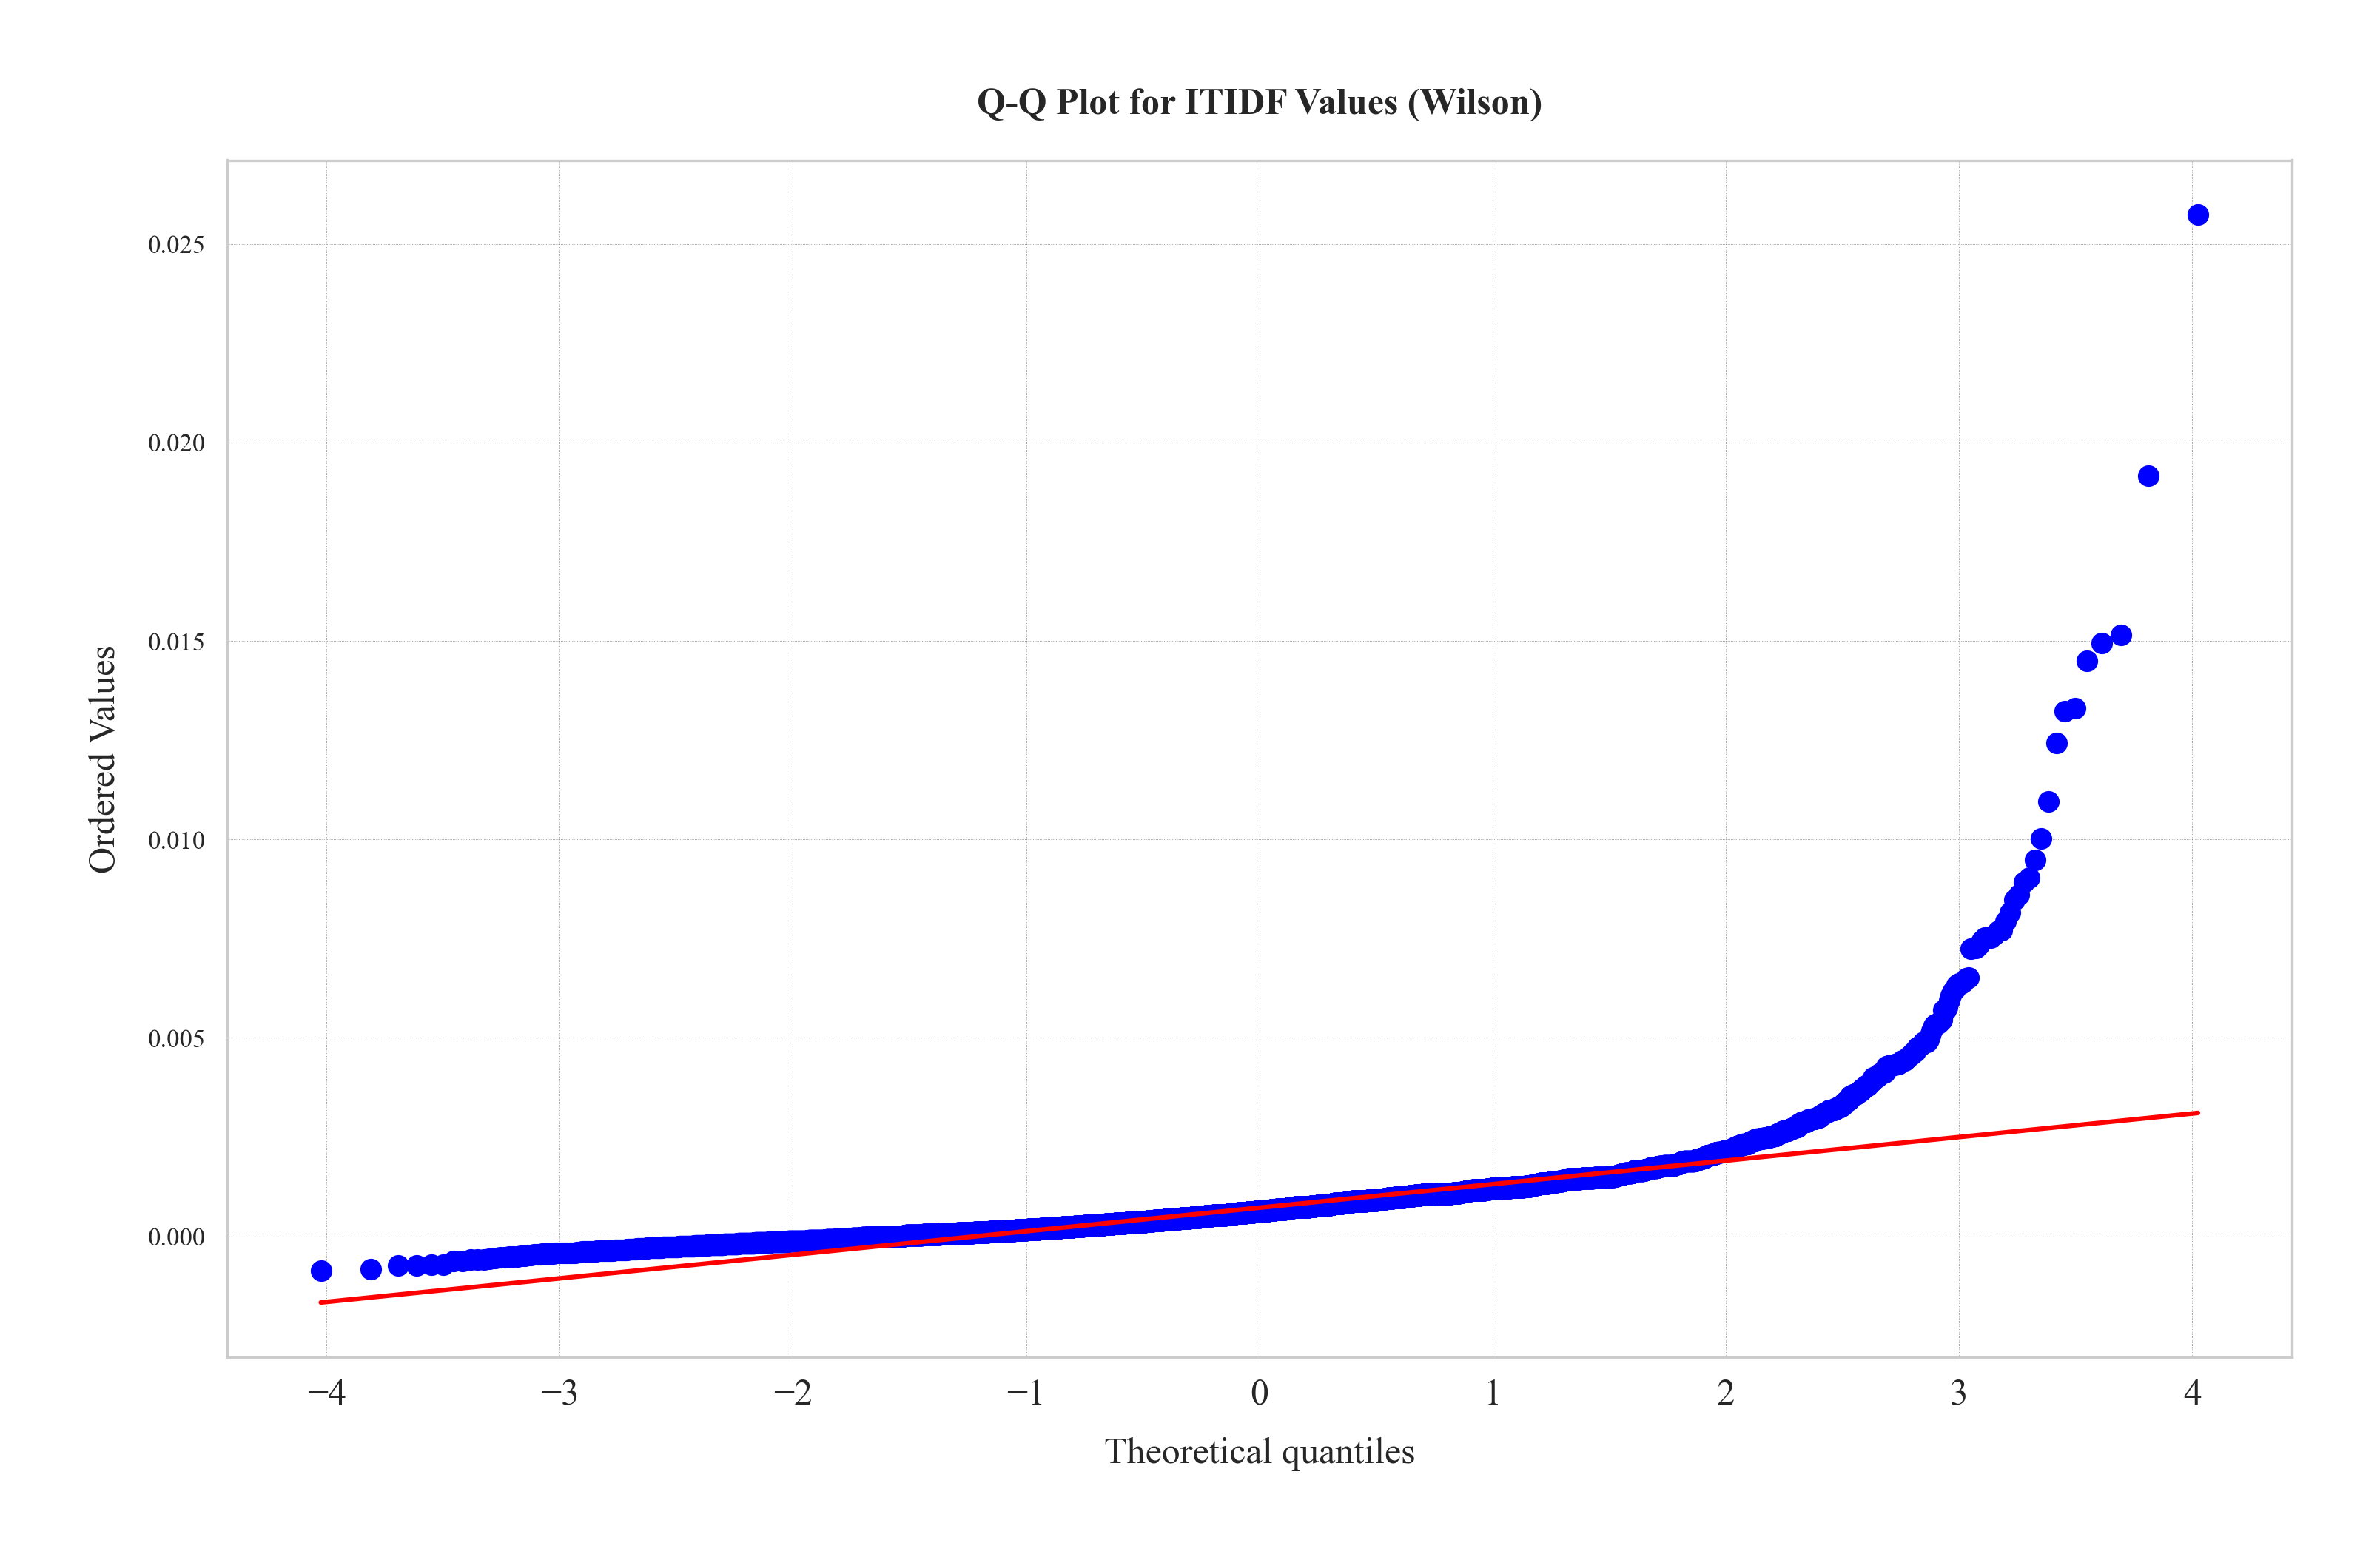

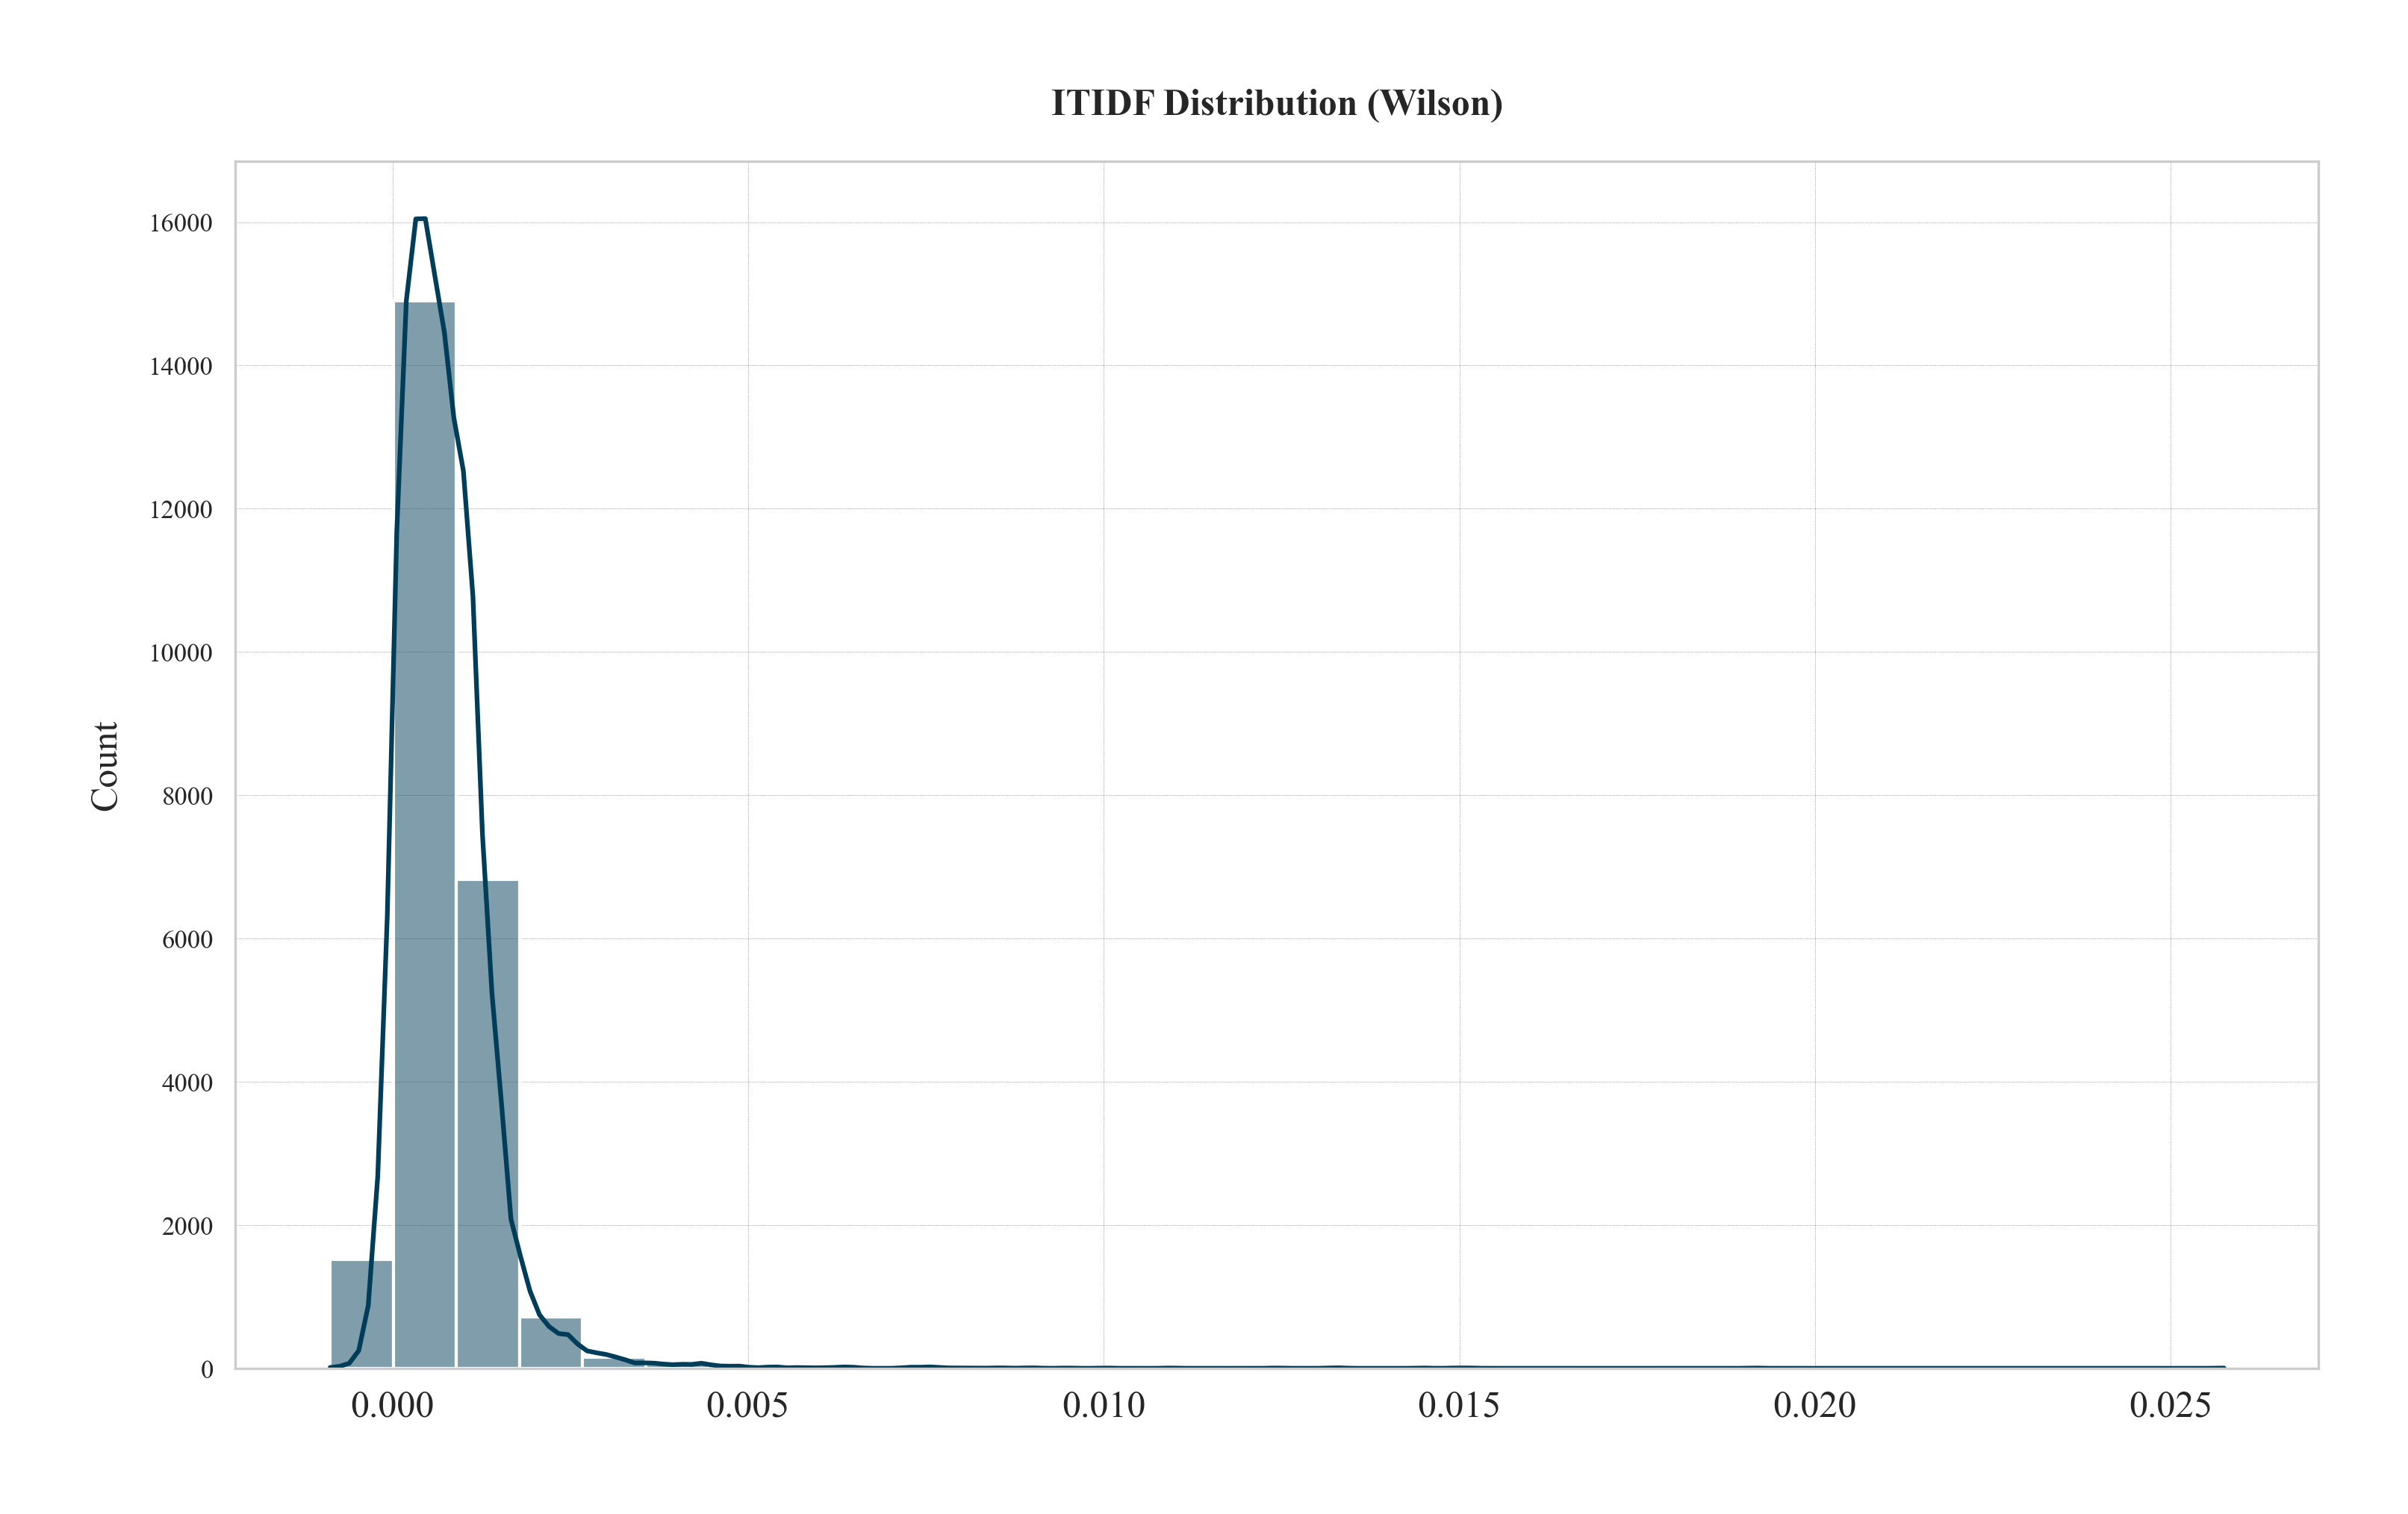

In [17]:
import scipy.stats as stats
# Q-Q plot for ITIDF values
def plot_qq(itidf, translator="Wilson"):
    """
    Create a Q-Q plot for the ITIDF values.
    
    Parameters:
    -----------
    itidf : list
        List of ITIDF values to plot
    """
    # Generate a Q-Q plot
    stats.probplot(itidf_W, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for ITIDF Values ({translator})")
    plt.savefig(f"/Users/debr/English-Homer/MVP_Green-Wilson/plots/Q-Q_Plot_{translator}.png")
    plt.show()

def plot_itidf_distribution(itidf, translator="Wilson"):
    """
    Plot the distribution of ITIDF values.
    
    Parameters:
    -----------
    itidf : list
        List of ITIDF values to plot
    """
    # Create a histogram of the ITIDF values
    sns.histplot(itidf, bins=30, kde=True)  # KDE adds a smoothed curve
    plt.title(f"ITIDF Distribution ({translator})")
    plt.savefig(f"/Users/debr/English-Homer/MVP_Green-Wilson/plots/ITIDF_Distribution_{translator}.png")
    plt.show()

# Plot Q-Q plot and distribution for ITIDF values for Wilson
plot_qq(itidf_W, "Wilson")
plot_itidf_distribution(itidf_W, "Wilson")

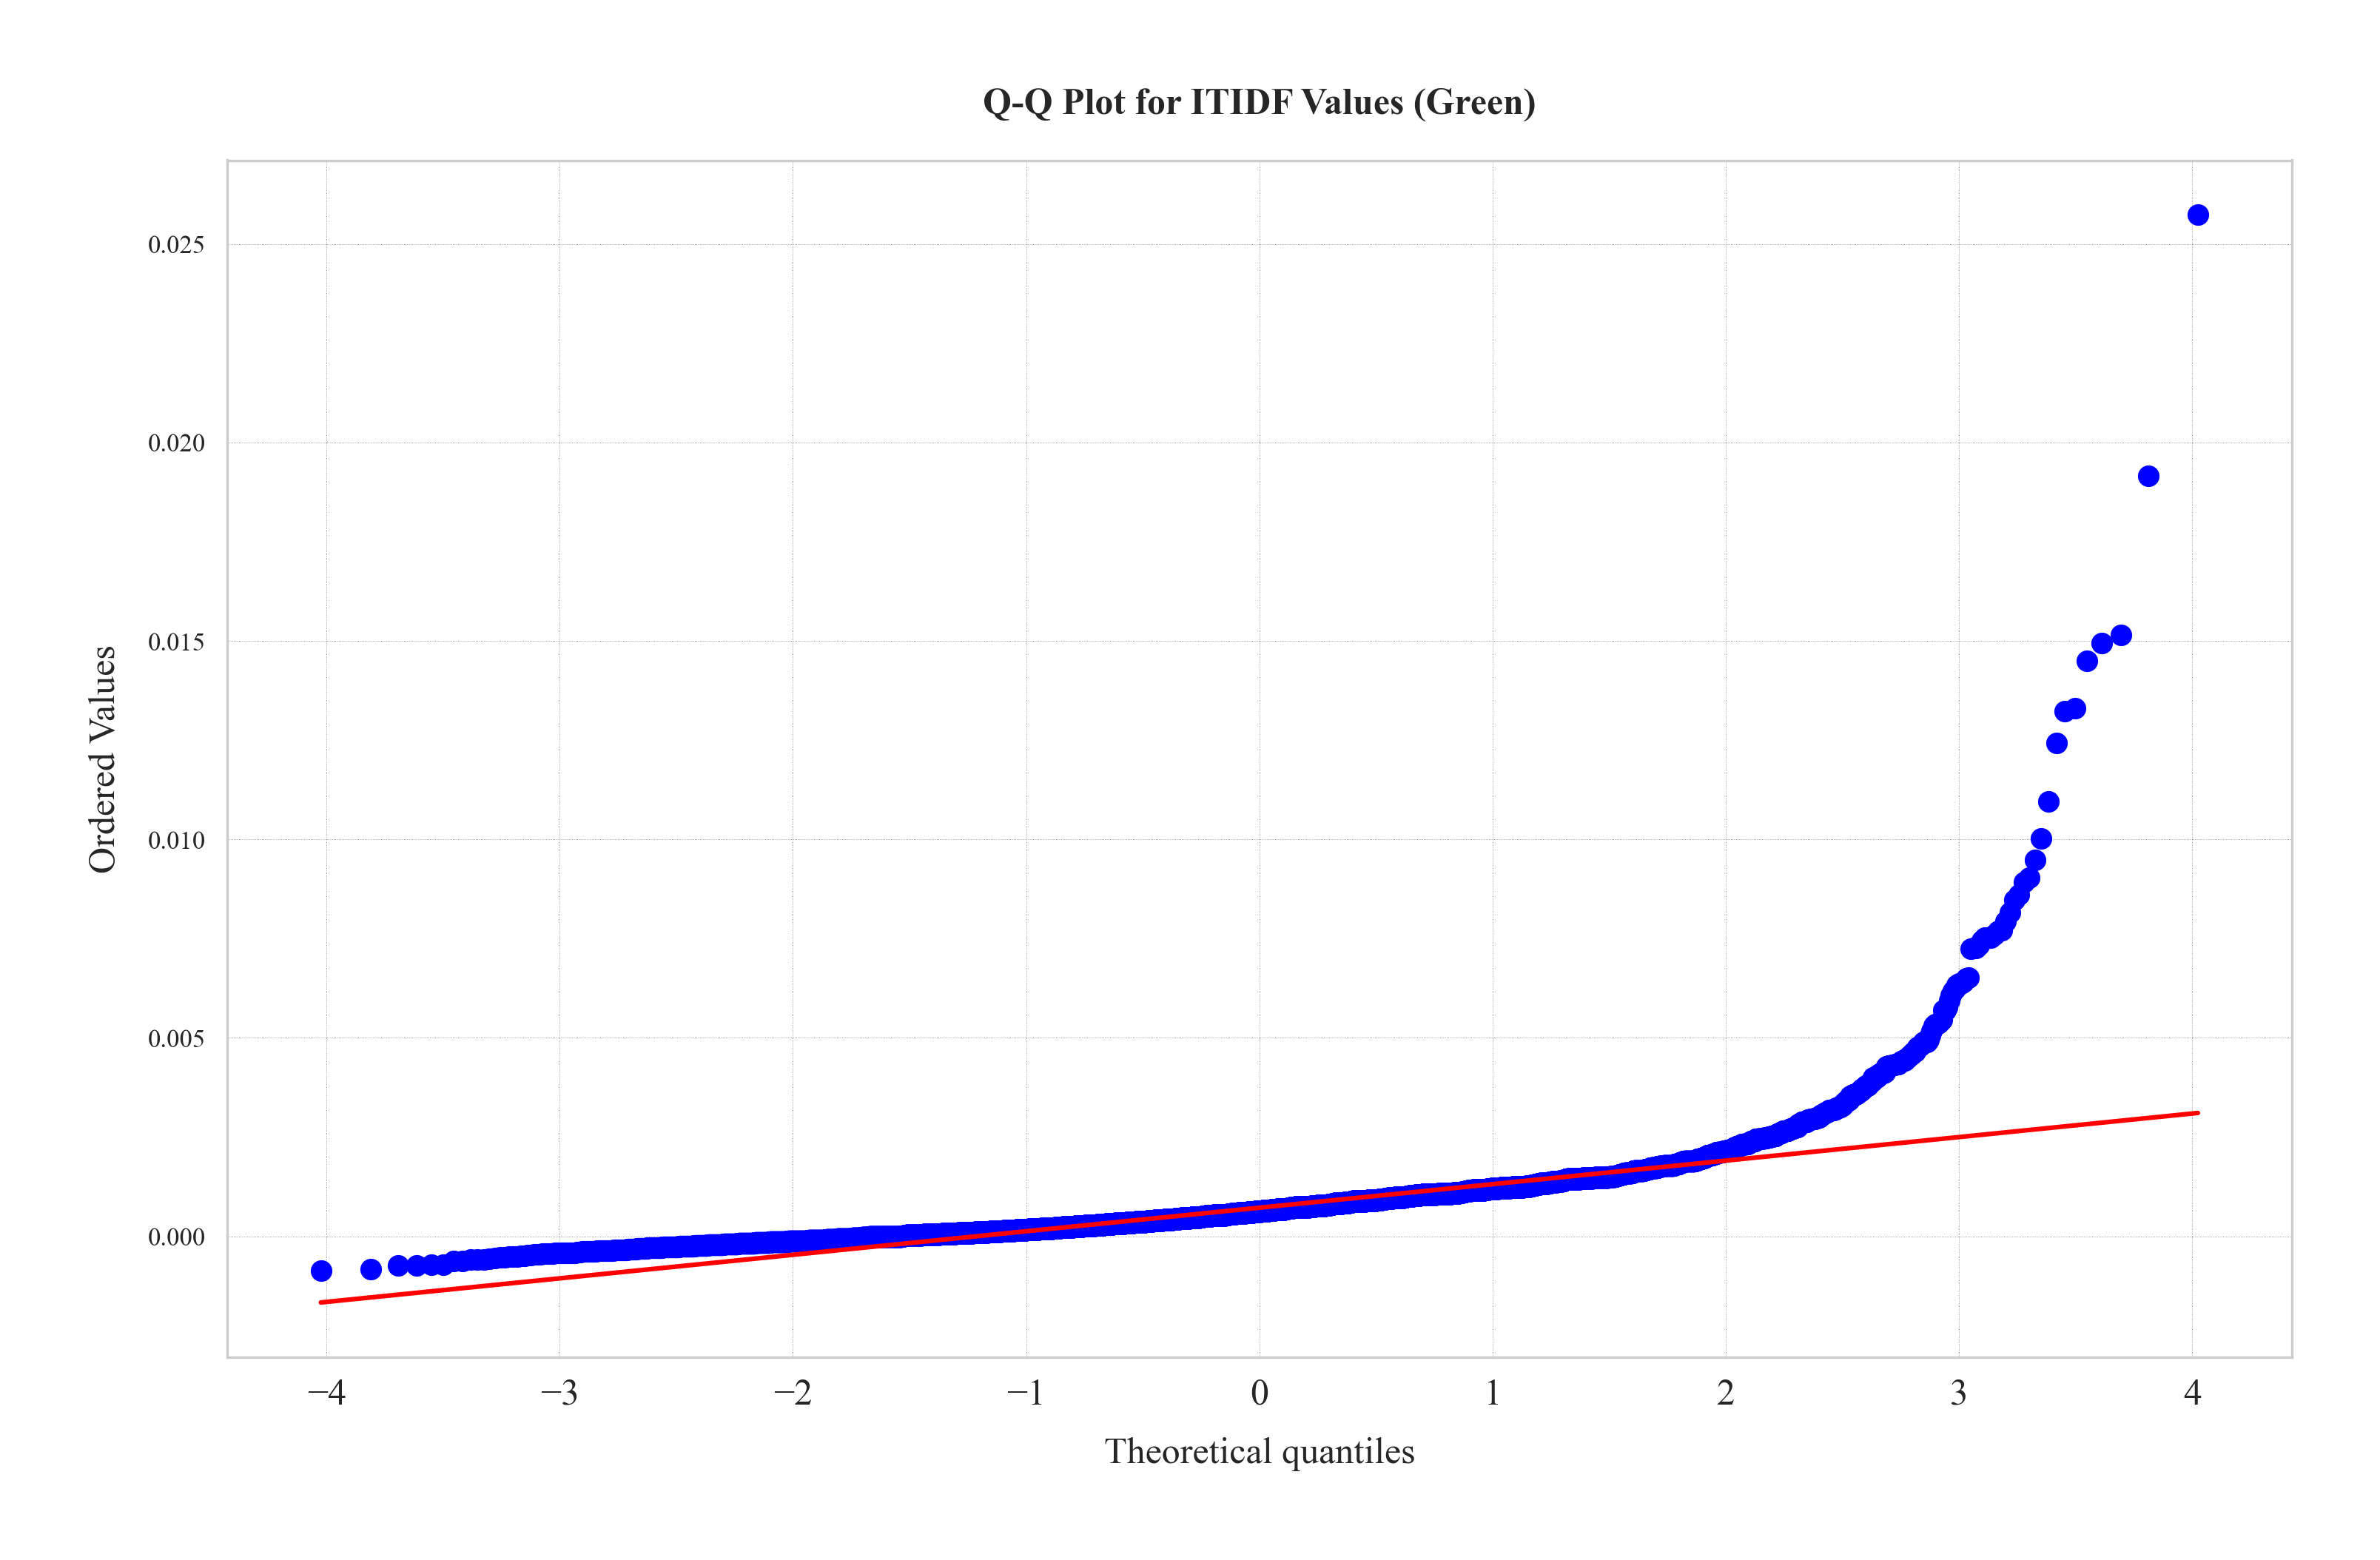

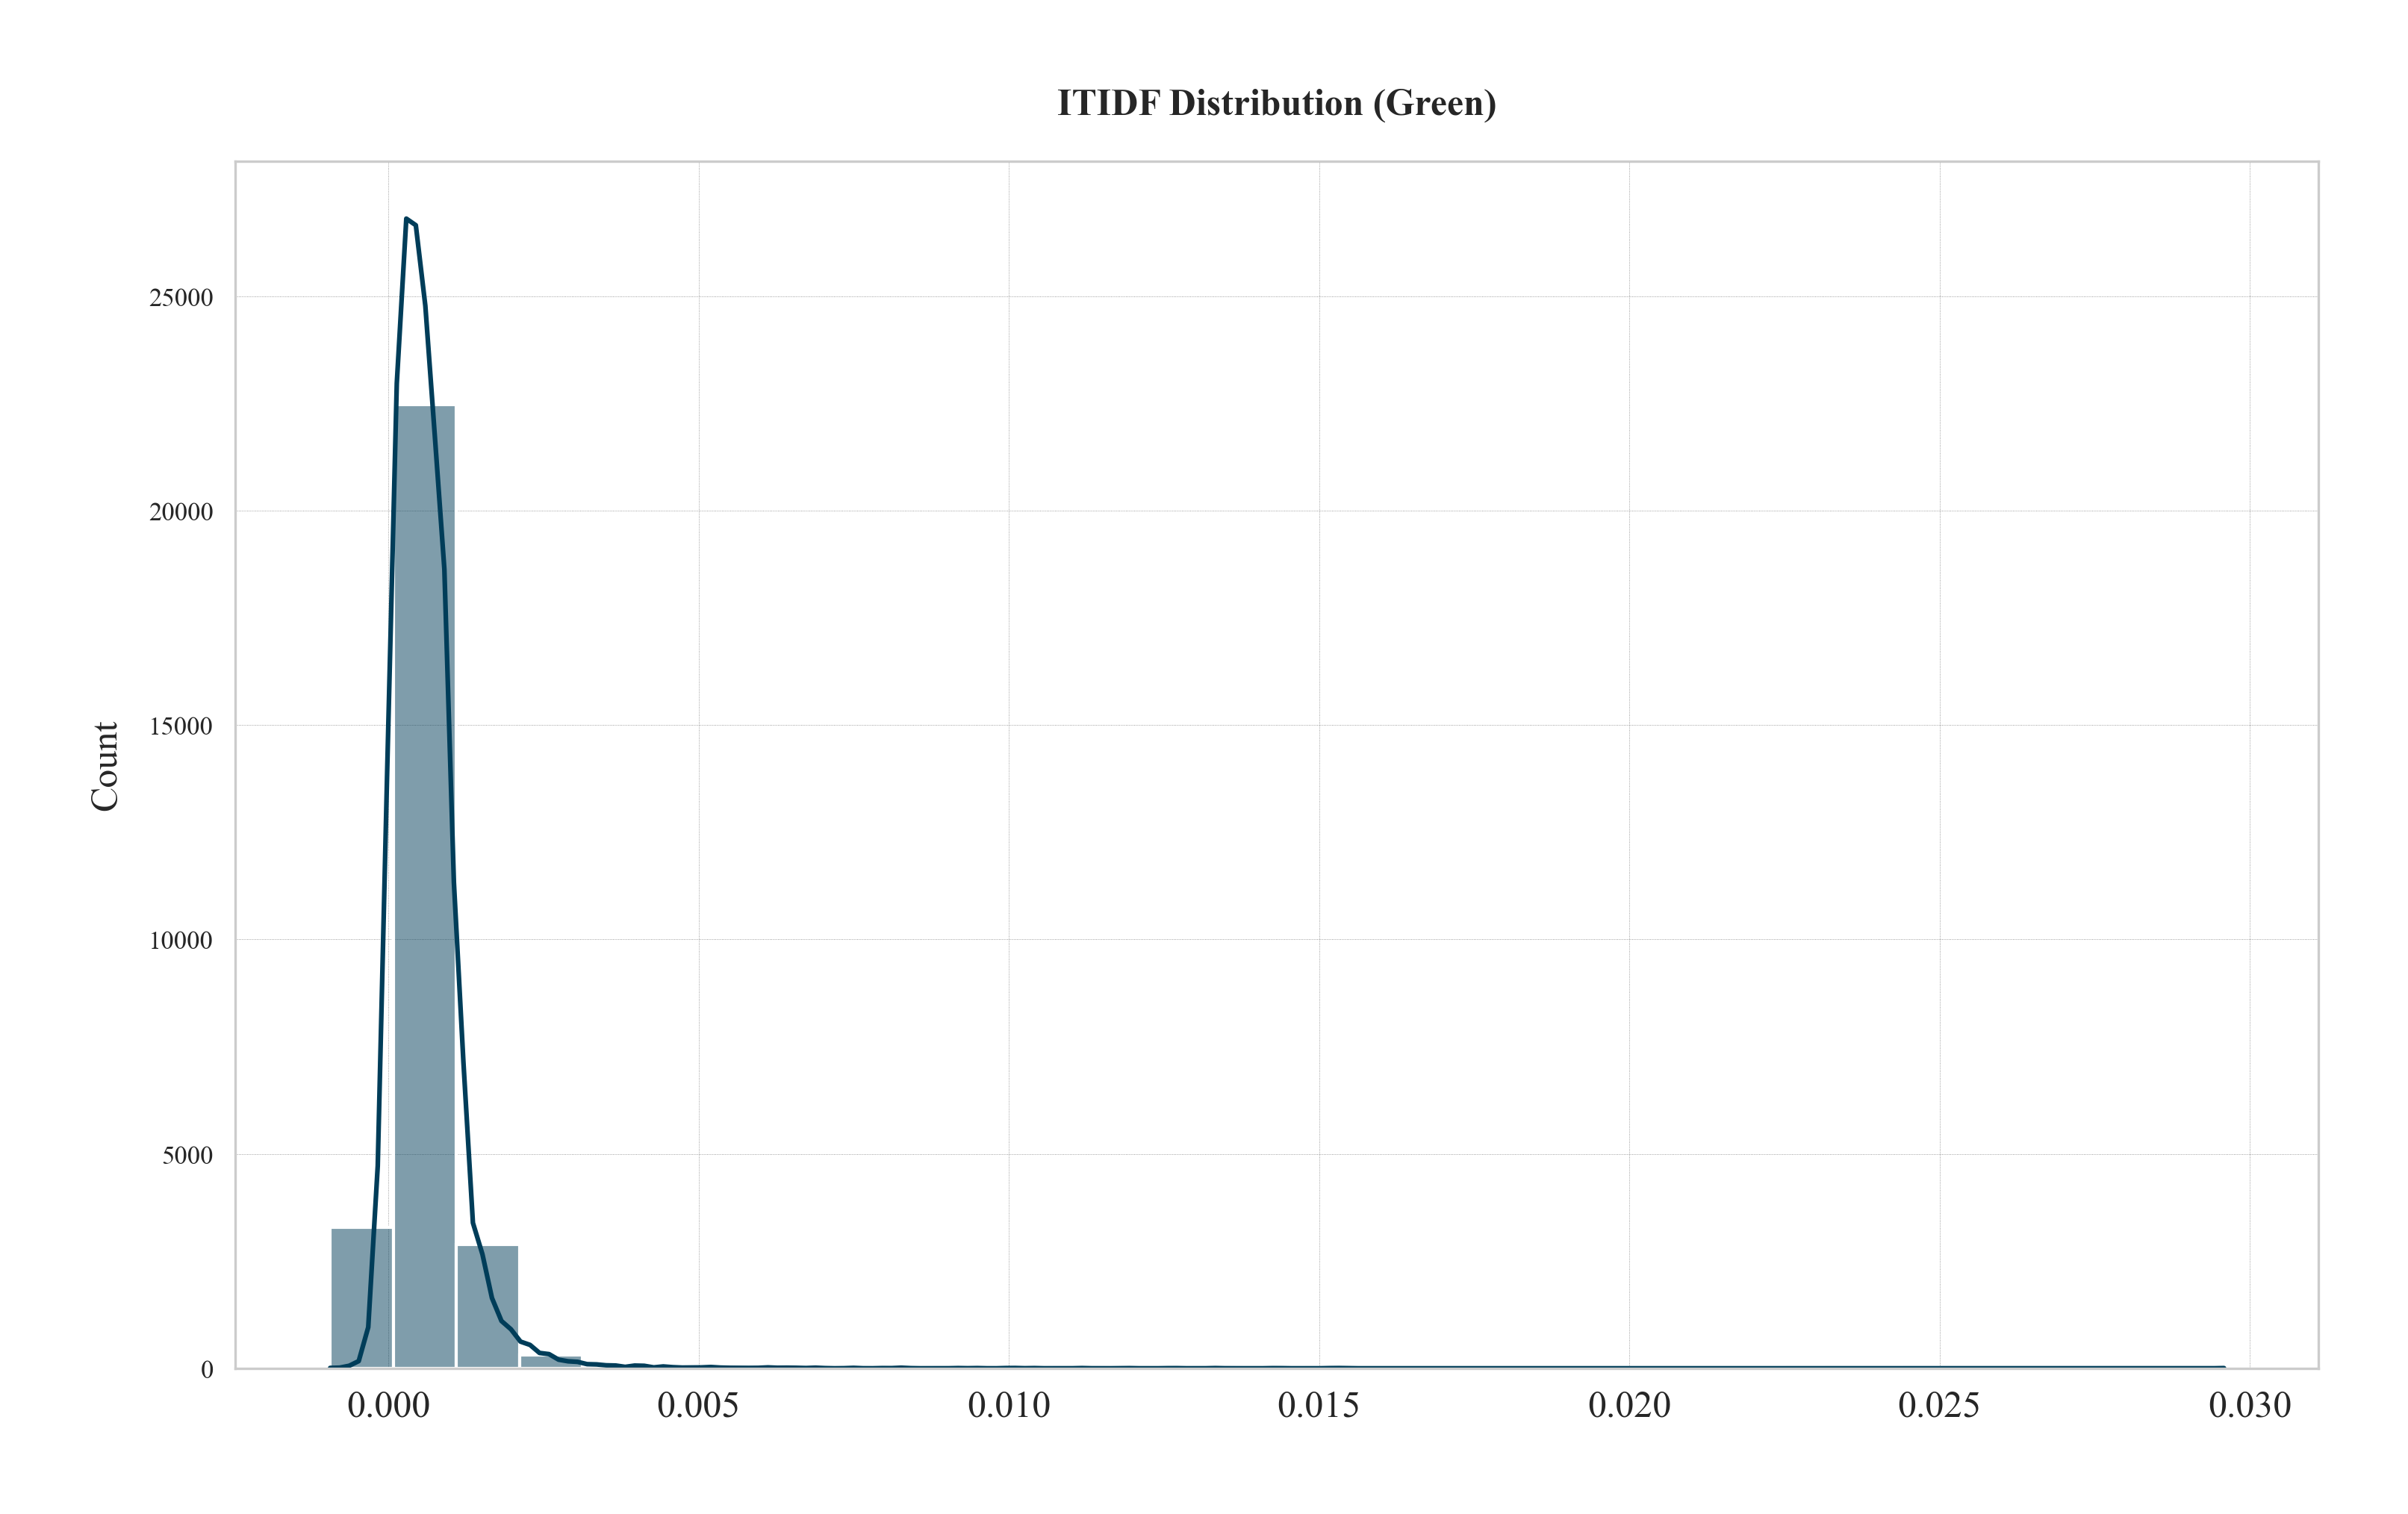

In [18]:
# Plot Q-Q plot and distribution for ITIDF values for Green
plot_qq(itidf_G, "Green")
plot_itidf_distribution(itidf_G, "Green")

In [11]:
from scipy.stats import shapiro
# Shapiro test for normality
def shapiro_test(data):
    """"
    Perform the Shapiro-Wilk test for normality from scipy.stats and print the results.

    Parameters:
    -----------
    data : list or array
        The data to be tested for normality.

    Returns: shapiro statistic and p-value

    """        
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test: p-value = {p}")

    if p > 0.05:
        print("Data appears to be normally distributed (fail to reject H0).")
    else:
        print("Data is not normally distributed (reject H0).")
    return stat, p

# Shapiro-Wilk test for normality
print("Wilson")
shapiro_test(itidf_W)
print("\n")
print("Green")
shapiro_test(itidf_G)

Wilson
Shapiro-Wilk Test: p-value = 1.9264430476087096e-105
Data is not normally distributed (reject H0).


Green
Shapiro-Wilk Test: p-value = 1.5939662570478783e-113
Data is not normally distributed (reject H0).


(np.float64(0.6885523258795925), np.float64(1.5939662570478783e-113))

In [12]:
# Mannwhitney U test for comparing ITIDF values
from scipy.stats import mannwhitneyu  # Import the actual function

def mannwhitneyu_test(x, y, alternative='two-sided'):
    """
    Perform the Mann-Whitney U test for comparing two independent samples.
    """
    stat, p = mannwhitneyu(x, y, alternative=alternative)  # Use SciPy's function
    print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

    if p < 0.05:
        print("Reject H₀: The distributions of the translations are significantly different.")
    else:
        print("Fail to reject H₀: No significant difference between the translations.")

# Run the test
mannwhitneyu_test(itidf_W, itidf_G, alternative='two-sided')

Mann-Whitney U test statistic: 398451440.5, p-value: 2.3169071909419926e-146
Reject H₀: The distributions of the translations are significantly different.


In [13]:
# Save tfidf dataframes
df_tfidf_W.to_csv("/Users/debr/English-Homer/MVP_Green-Wilson/df_tfidf_W.csv", index=False)
df_tfidf_G.to_csv("/Users/debr/English-Homer/MVP_Green-Wilson/df_tfidf_G.csv", index=False)